# Titanic survival predictor

Prediction model for surviving the titanic crash using the classic dataset. Playing around with the data to set it up nicely for model testing. Comparing the performance of different ML models of the data. 

Structure:

1. Load data and import libraries
2. EDA
3. Data preprocessing and feature engineering
   - 3.1) Imputation of Age data
   - 3.2) Combining features
   - 3.3) Feature encoding
   - 3.4) Omission of features
4. Model training and testing
   - 4.1) Logistic regression
   - 4.2) KNN
   - 
   


## 1) Load data and import packages

In [217]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from sklearn import preprocessing, neighbors, svm

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier


df = pd.read_csv('Titanic-Dataset.csv')

## 2) Explanatory data analysis

Basic info of the data shape, columns, data types, missing values etc. The profile report combines relevant information about the variables of the dataset, and visualizes interactions and correlations. Thus, less plotting needed here.

In [218]:
print('\n\n______________________________________________\n\n')
print(f'Shape:\n\n{df.shape}')
print('\n\n______________________________________________\n\n')
print(f'Target value counts:\n\n{df.Survived.value_counts()}')
print('\n\n______________________________________________\n\n')
print(f'Describe:\n\n{df.describe()}')
print('\n\n______________________________________________\n\n')
print(f'Missing data (nan values):\n\n{df.isnull().sum()}')
print('\n\n______________________________________________\n\n')
print(f'Info:\n\n{df.info()}')
print('\n\n______________________________________________\n\n')
print(f'Dtypes:\n\n{df.dtypes}')
print('\n\n______________________________________________\n\n')
print(f'Head:\n\n{df.head()}')
print('\n\n______________________________________________\n\n')



______________________________________________


Shape:

(891, 12)


______________________________________________


Target value counts:

Survived
0    549
1    342
Name: count, dtype: int64


______________________________________________


Describe:

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.80605

In [219]:
# Generate the report
profile = ProfileReport(df, title='Titanic_survival_profile_report')

# Save the report to .html
profile.to_file('titanic_survival_profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 381.77it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3) Data preprocessing and feature engineering

Based on the EDA, the data needs to be cleaned to usable format. Here the useful features are chosen, and techniques, such as imputation, omission, encoding, and binning are utlized. 


The profile report and basic pandas dercriptive statistics provide great insight of each feature in the dataset. The data contains 5 numeric variables, 4 categorical, and 3 textual. Short descriptions and needed actions of each of the 12 variables:

PassengerId: basically a running index for data rows.

Survived: binary target variable. The columns has clean ones and zeros. No missing values.

Pclass: passanger class in the ship. Numerical categorical ordered feature. No missing values.

Name: unique textual variables. Sex is also in a separate column.

Sex: two textual categorical equal classes. No missing values.

Age: numerical continuous variable. Should be binned to age groups to improve learning. ~20% of missing values is too much to be omitted so imputation of some sort is needed.

SibSp: number of siblings and spouses on board with the passenger. Continuous numerical variable with 8 distinct values. No missing values.

Parch: number of parents and kids on board with the passenger. Continuous numerical variable with 8 distinct values. No missing values.

Ticket: textual variable with 681 distinct values.

Fare: price paid for ticket order. A single order can have multiple tickets.

Cabin: textual variable with 147 distinct values. 687 missing values so likely to be omitted.

Embarked: the location where the passenger boarded the ship. Textual categorical variable with three distinct equal values.

### 3.1) Imputation of Age data

Let's use random imputation for grouped data. That is, the data is grouped based on useful variables and a random sample for each group is used to pad the missing values. 

In [220]:
# Effect of 'Miss'/'Master'/'Mrs'/'Mr' in name column to the Age
print(f'Median age of Miss: {df.loc[df["Name"].str.contains("Miss")]["Age"].median()}, nbr of samples: {len(df.loc[df["Name"].str.contains("Miss")]["Age"])}')
print(f'Median age of Mrs: {df.loc[df["Name"].str.contains("Mrs")]["Age"].median()}, nbr of samples: {len(df.loc[df["Name"].str.contains("Mrs")]["Age"])}')
print(f'Median age of a female: {df.loc[df["Sex"] == "female"]["Age"].median()}, nbr of samples: {len(df.loc[df["Sex"] == "female"]["Age"])}')
print('_______________')
print(f'Median age of Master: {df.loc[df["Name"].str.contains("Master")]["Age"].median()}, nbr of samples: {len(df.loc[df["Name"].str.contains("Master")]["Age"])}')
print(f'Median age of Mr: {df.loc[df["Name"].str.contains("Mr")]["Age"].median()}, nbr of samples: {len(df.loc[df["Name"].str.contains("Mr")]["Age"])}')
print(f'Median age of a male: {df.loc[df["Sex"] == "male"]["Age"].median()}, nbr of samples: {len(df.loc[df["Sex"] == "male"]["Age"])}')
print('_______________')

# The correlation heatmap shows that PClass correlates with Age quite strongly
print(f'Median age of Pclass 1: {df.loc[df["Pclass"] == 1]["Age"].median()}')
print(f'Median age of Pclass 2: {df.loc[df["Pclass"] == 2]["Age"].median()}')
print(f'Median age of Pclass 3: {df.loc[df["Pclass"] == 3]["Age"].median()}')

# Add title column
def get_title(name_str):
    for title in ['Mrs', 'Mr', 'Miss', 'Master']:
        if title in name_str:
            return title
    return 'Unknown'

df['Title'] = df['Name'].apply(get_title)

Median age of Miss: 21.0, nbr of samples: 182
Median age of Mrs: 35.0, nbr of samples: 129
Median age of a female: 27.0, nbr of samples: 314
_______________
Median age of Master: 3.5, nbr of samples: 40
Median age of Mr: 31.0, nbr of samples: 647
Median age of a male: 29.0, nbr of samples: 577
_______________
Median age of Pclass 1: 37.0
Median age of Pclass 2: 29.0
Median age of Pclass 3: 24.0


The Title and Pclass columns affect age and can be utilized in the imputation.

Master title describes very well the age of the passenger. Miss, however, can be a kid or an unmarried young woman. Even so, passengers with the Miss title are unlikely to have kids of their own so the Parch field for these people mainly describes whether the passenger has parents on board or not. The passengers that have Miss title and do not have parents on board are likely young adults and not kids.

In [221]:
print(f'Median age of Miss with parents: {df.loc[(df["Name"].str.contains("Miss")) & (df["Parch"] > 0)]["Age"].median()}, nbr of samples: {len(df.loc[(df["Name"].str.contains("Miss")) & (df["Parch"] > 0)]["Age"])}')
print(f'Median age of Miss without parents: {df.loc[(df["Name"].str.contains("Miss")) & (df["Parch"] == 0)]["Age"].median()}, nbr of samples: {len(df.loc[(df["Name"].str.contains("Miss")) & (df["Parch"] == 0)]["Age"])}')

Median age of Miss with parents: 9.0, nbr of samples: 64
Median age of Miss without parents: 26.0, nbr of samples: 118


As seen, the number of Parch associated with every Miss on board has an effect on the age. Let's modify the adult Miss passengers with a new title. 

In [222]:
# Modify title for assumed adults with the Miss title
df.loc[(df["Name"].str.contains("Miss")) & (df["Parch"] == 0), 'Title'] = 'Miss_adult'

The remainining null age data contains only one row that has a more unique title. Let's modify it for the man. 

In [223]:
print(df.loc[(df.Title == 'Unknown') & (df.Age.isnull())])

# Assign the remaining male doctor with title Mr
df.loc[(df['Title'] == 'Unknown') & (df['Age'].isnull()), 'Title'] = 'Mr'

     PassengerId  Survived  Pclass                       Name   Sex  Age  \
766          767         0       1  Brewe, Dr. Arthur Jackson  male  NaN   

     SibSp  Parch  Ticket  Fare Cabin Embarked    Title  
766      0      0  112379  39.6   NaN        C  Unknown  


Let's compute the ticket fare per person and check whether this has an effect on age like Pclass did.

All people that were on the same order have the same ticket. Let's map the number of specific ticket instances for the ticket holders, compute the fare per person, and plot the dstribution.

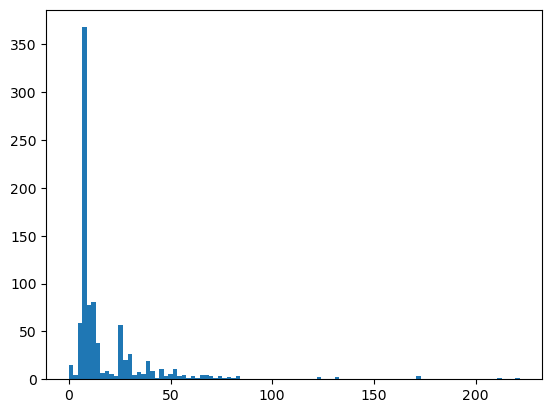

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,people_per_order,fare_per_person
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Mr,2,123.7604
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Miss_adult,3,170.7764
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,Mrs,2,123.7604
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,Miss,2,131.1875
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Mr,1,211.5000
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,Mr,1,221.7792
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr,3,170.7764
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Mr,3,170.7764
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,Miss,2,131.1875


In [224]:
# Map the number of ticket instances for each row
ticket_counts = df['Ticket'].value_counts()
df['people_per_order'] = df['Ticket'].map(ticket_counts)

# Calculate the fare per person
df['fare_per_person'] = df['Fare'] / df['people_per_order']

# Plot the distribution
plt.figure()
plt.hist(df.fare_per_person, bins=100)
plt.show()

# Check the highest fares for irregularities
df.loc[df.fare_per_person > 100]

Bin the fare per person somewhat evenly. 

In [225]:
# Bin the data into equally large groups with quantile binning
df['fare_per_person_binned'] = pd.qcut(df['fare_per_person'], q=5, labels=False)

for i, (_, fare_group) in enumerate(df.groupby('fare_per_person_binned')):
    print(f'Median age of fare per person group {i}: {fare_group["Age"].median()}, nbr of samples: {len(fare_group)}')

Median age of fare per person group 0: 22.0, nbr of samples: 180
Median age of fare per person group 1: 26.0, nbr of samples: 218
Median age of fare per person group 2: 26.0, nbr of samples: 138
Median age of fare per person group 3: 33.0, nbr of samples: 189
Median age of fare per person group 4: 36.0, nbr of samples: 166


Try different number of bins and see how the created variable compares to Pclass regarding its correlation with the target variable. 

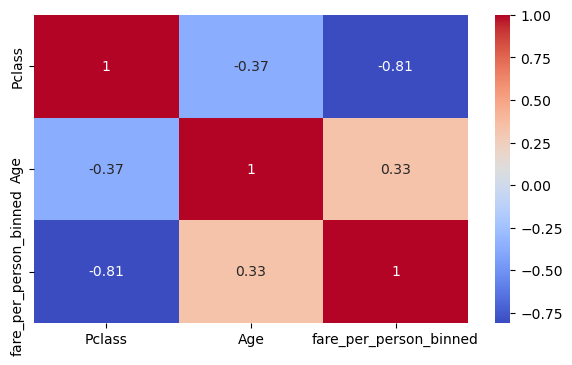

In [226]:
plt.figure(figsize=(7, 4))
sns.heatmap(df.loc[:, df.columns.isin(['Pclass', 'fare_per_person_binned', 'Age'])].corr(), annot=True, cmap='coolwarm')
plt.show()

Seems that even though fare_per_person has more bins and equal distribution among them, the unbalanced Pclass variable correlates better with the Age. Thus, the fare_per_person is not used for imputation of Age.

Finally, check that the imputation grouping data has nothing suspicious going on. That is, the median ages make sense and each group has a reasonible number of samples.

In [227]:
# Final check that the grouping variables have no missing values
print(df.loc[:, ['Sex', 'Title', 'Pclass']].isnull().sum())
print('\n')

# Print the group medians
print(df.groupby(['Pclass','Sex','Title'])['Age'].median())
print('\n')

# Print the group sizes
print(df.groupby(['Pclass','Sex','Title'])['Age'].size())
print('\n')

# Print the groups of the passengers with missing age
print(df.loc[df.Age.isnull()].groupby(['Pclass','Sex','Title'])['Age'].size())
print('\n')

Sex       0
Title     0
Pclass    0
dtype: int64


Pclass  Sex     Title     
1       female  Miss          20.0
                Miss_adult    32.0
                Mrs           41.5
                Unknown       28.5
        male    Master         4.0
                Mr            40.0
                Unknown       47.5
2       female  Miss           7.0
                Miss_adult    30.0
                Mrs           32.0
                Unknown       28.0
        male    Master         1.0
                Mr            31.0
                Unknown       46.5
3       female  Miss           5.0
                Miss_adult    21.0
                Mrs           31.0
        male    Master         4.0
                Mr            26.0
Name: Age, dtype: float64


Pclass  Sex     Title     
1       female  Miss           16
                Miss_adult     30
                Mrs            44
                Unknown         4
        male    Master          3
                Mr            10

Perform the age imputation based on Pclass, Sex, and Pclass. 

In [228]:
# Impute the missing Age values with random choices from imputation groups
def fill_age(x, df1):
    ages = df1[(df1.Pclass == x.Pclass) & (df1.Sex == x.Sex) & (df1.Title == x.Title)]['Age'].values
    return np.random.choice(ages, size=1)[0]

df1 = df.loc[df['Age'].notnull()]
df['age'] = df.apply(lambda x: fill_age(x, df1) if np.isnan(x['Age']) else x['Age'], axis=1)

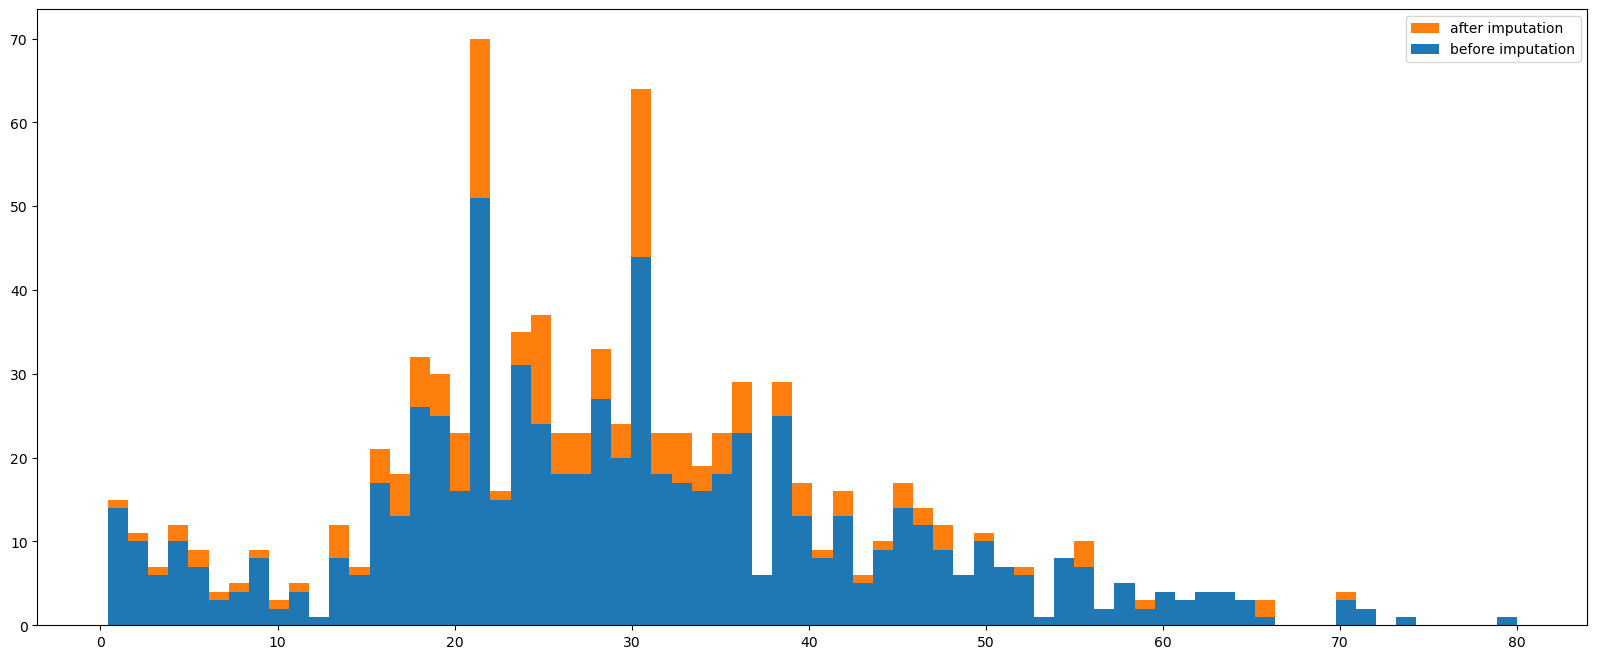

In [229]:
# Plot age distributions before and after imputation
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.hist(df['age'], bins=70, color='C1', label='after imputation')
ax.hist(df['Age'], bins=70, color='C0', label='before imputation')
plt.legend()
plt.show()

Bin the age data. Find groups that distinguish, especially, the younger age groups.

In [230]:
df['age_binned'] = pd.cut(df['age'], bins=[0, 4, 12, 18, 25, 35, 45, 60, 100], labels=[1, 2, 3, 4, 5, 6, 7, 8])

In [231]:
print(df.age_binned.value_counts())
for i in range(8):
    max = df.loc[df['age_binned'] == i+1]['age'].max()
    min = df.loc[df['age_binned'] == i+1]['age'].min()
    print(f'Group {i+1}: min {min}, max {max}')

age_binned
5    255
4    211
6    136
7     93
3     90
1     45
2     36
8     25
Name: count, dtype: int64
Group 1: min 0.42, max 4.0
Group 2: min 5.0, max 12.0
Group 3: min 13.0, max 18.0
Group 4: min 19.0, max 25.0
Group 5: min 26.0, max 35.0
Group 6: min 36.0, max 45.0
Group 7: min 45.5, max 60.0
Group 8: min 61.0, max 80.0


### 3.2) Combining features

Combine Parch and Sibsp variables into one and see how each correlates with target variable.


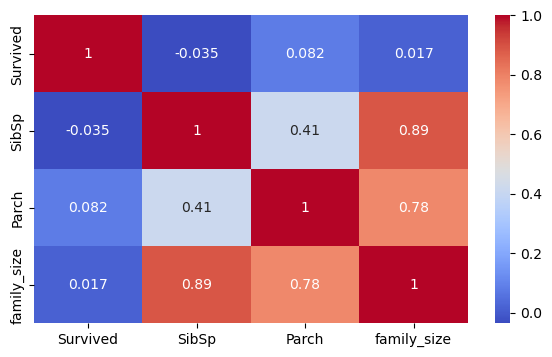

In [232]:
df['family_size'] = df['Parch'] + df['SibSp']

plt.figure(figsize=(7, 4))
sns.heatmap(df.loc[:, df.columns.isin(['Parch', 'SibSp', 'family_size', 'Survived'])].corr(), annot=True, cmap='coolwarm')
plt.show()

By itself, none of the three parameters have a strong correlation with the target variable. Collinearity might be problematic for linear models so should possibly test the variables one by one when training models. 

### 3.3) Feature encoding

Encode Sex, Embarked, Title, Pclass, and binned age and fare_per_person columns

Binary label encoding for Sex and one-hot encoding for Embarked.


In [233]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
df = pd.concat([df, dummies], axis=1)

df['Embarked_C'] = df['Embarked_C'].astype('int')
df['Embarked_Q'] = df['Embarked_Q'].astype('int')
df['Embarked_S'] = df['Embarked_S'].astype('int')

In [234]:
dummies = pd.get_dummies(df['Title'], prefix='Title')
df = pd.concat([df, dummies], axis=1)

df['Title_Master'] = df['Title_Master'].astype('int')
df['Title_Miss'] = df['Title_Miss'].astype('int')
df['Title_Miss_adult'] = df['Title_Miss_adult'].astype('int')
df['Title_Mr'] = df['Title_Mr'].astype('int')
df['Title_Mrs'] = df['Title_Mrs'].astype('int')
df['Title_Unknown'] = df['Title_Unknown'].astype('int')

In [235]:
dummies = pd.get_dummies(df['Pclass'], prefix='Pclass')
df = pd.concat([df, dummies], axis=1)

df['Pclass_1'] = df['Pclass_1'].astype('int')
df['Pclass_2'] = df['Pclass_2'].astype('int')
df['Pclass_3'] = df['Pclass_3'].astype('int')

In [236]:
dummies = pd.get_dummies(df['age_binned'], prefix='age_binned')
df = pd.concat([df, dummies], axis=1)

df['age_binned_1'] = df['age_binned_1'].astype('int')
df['age_binned_2'] = df['age_binned_2'].astype('int')
df['age_binned_3'] = df['age_binned_3'].astype('int')
df['age_binned_4'] = df['age_binned_4'].astype('int')
df['age_binned_5'] = df['age_binned_5'].astype('int')
df['age_binned_6'] = df['age_binned_6'].astype('int')
df['age_binned_7'] = df['age_binned_7'].astype('int')
df['age_binned_8'] = df['age_binned_8'].astype('int')

In [237]:
dummies = pd.get_dummies(df['fare_per_person_binned'], prefix='fare_per_person_binned')
df = pd.concat([df, dummies], axis=1)

df['fare_per_person_binned_0'] = df['fare_per_person_binned_0'].astype('int')
df['fare_per_person_binned_1'] = df['fare_per_person_binned_1'].astype('int')
df['fare_per_person_binned_2'] = df['fare_per_person_binned_2'].astype('int')
df['fare_per_person_binned_3'] = df['fare_per_person_binned_3'].astype('int')
df['fare_per_person_binned_4'] = df['fare_per_person_binned_4'].astype('int')

Apparently, when dealing with one-hot encoding, one has to avoid the dummy variable trap. This occurs when dummy variable is an exact combination of other dummies. In our case, Pclass_1 = 1 - Pclass_2 - Pclass_3. This can be avoided by excluding one of the dummies.

In [238]:
df = df.drop(['Embarked_C', 'Title_Master', 'fare_per_person_binned_0', 'age_binned_1'], axis=1)

### 3.4) Omission of features

Exclusion of variables that are not considered significant for the model development or have too many missing values for imputation.


In [239]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Title', 'Embarked', 'people_per_order', 'SibSp', 'Parch', 'age', 'Fare', 'Pclass',
              'fare_per_person', 'fare_per_person_binned', 'age_binned', 'family_size'], axis=1)

Check the correlations among the remaining features.

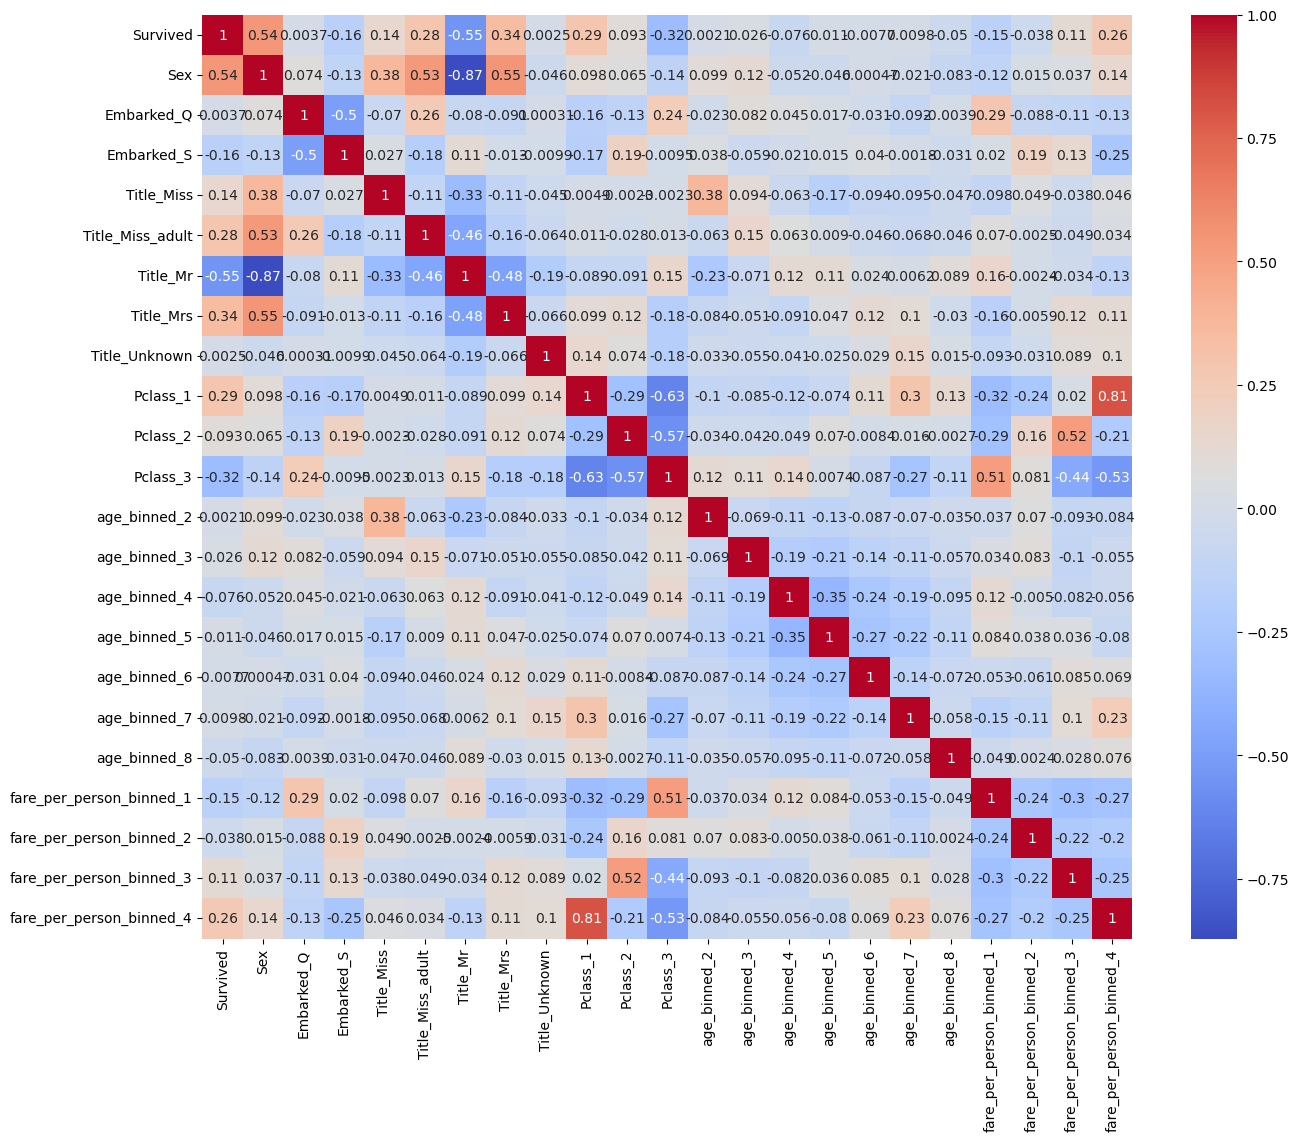

In [240]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## 4) Model training and testing

4.1 Logistic regression<br>
4.2 KNN<br>
4.3 SVM<br>
4.4 Decision tree<br>
4.5 Random forest<br>
4.6 XGBoost<br>


See how different models perform on the data with selected features.

In [241]:
def get_train_and_test_data(X, y):

    '''
    Parameters:
    X: matrix of features
    y: vector of targets

    Returns:
    X_train, X_test: matrices of features
    X_train, X_test: matrices of standardized features
    y_train, y_test: vectors of targets
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardization for distance-dependent models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test

def cross_validate_model(model, X, y, n_folds=5, return_accuracy:bool=False):

    '''
    Parameters:
    model: scikit ML model
    X: feature matrix
    y: one-dimensional array of targets
    '''

    # weighted metrics due to class imbalance
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    results = cross_validate(model, X, y, cv=n_folds, scoring=scoring)

    if return_accuracy:
        return results['test_accuracy'].mean()
    else:
        print('Cross-validated mean results:')
        print(f"Accuracy:  {results['test_accuracy'].mean():.3f}")
        print(f"Precision: {results['test_precision_weighted'].mean():.3f}")
        print(f"Recall:    {results['test_recall_weighted'].mean():.3f}")
        print(f"F1 Score:  {results['test_f1_weighted'].mean():.3f}\n")

def compute_and_visualize_confusion_matrix(model, X, y):

    '''
    Parameters:
    model: scikit ML model
    X: feature matrix
    y: one-dimensional array of targets
    '''

    X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test = get_train_and_test_data(X, y)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()

In [242]:
# Assign features and targets
X = df.drop(['Survived'], axis=1)
y = df['Survived']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4.1) Logistic regression

Cross-validated mean results:
Accuracy:  0.814
Precision: 0.813
Recall:    0.814
F1 Score:  0.812

Confusion Matrix:
[[89 16]
 [17 57]]



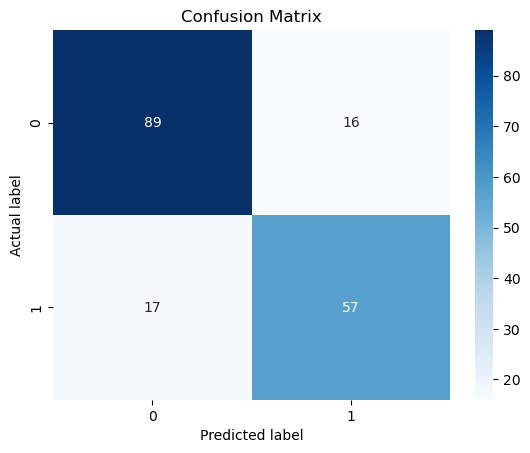

In [243]:
model = LogisticRegression()

# Cross-validation (on entire data)
cross_validate_model(model, X_scaled, y)

# Confusion matrix with one split
compute_and_visualize_confusion_matrix(model, X_scaled, y)

## 4.2) KNN

Loop a few number of neighbors and select thebest performing configuration.

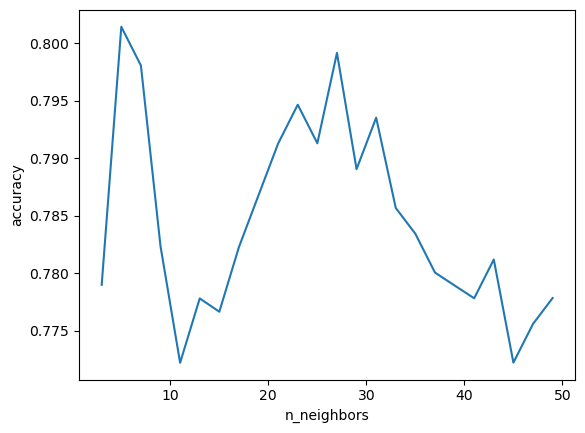

Number of neighbors that maximises accuracy: 5
Cross-validated mean results:
Accuracy:  0.778
Precision: 0.787
Recall:    0.778
F1 Score:  0.764

Confusion Matrix:
[[95 10]
 [39 35]]



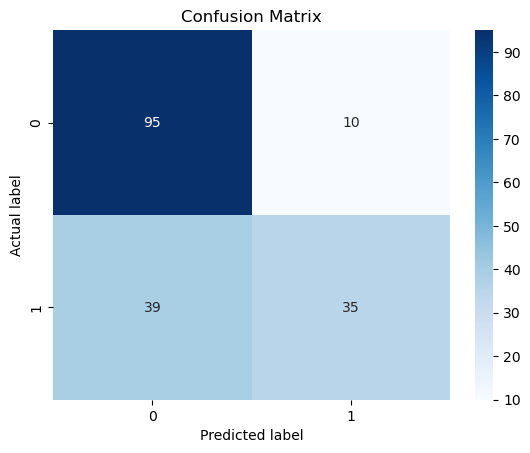

In [244]:
n_neighbors = np.arange(3, 51, 2)

acc = []
for n in n_neighbors:
    model = neighbors.KNeighborsClassifier(n_neighbors=n)

    # Cross-validation (on entire data)
    accuracy = cross_validate_model(model, X_scaled, y, return_accuracy=True)
    acc.append(accuracy)

plt.figure()
plt.plot(n_neighbors, acc)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

n_max_acc = n_neighbors[np.array(acc).argmax()]
print(f"Number of neighbors that maximises accuracy: {n_max_acc}")

# Best performing model
neighbors.KNeighborsClassifier(n_neighbors=n_max_acc)
cross_validate_model(model, X_scaled, y)

# Confusion matrix with one split
compute_and_visualize_confusion_matrix(model, X_scaled, y)

## 4.3) SVM

